# Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, we will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.




## Importing required libraries and dataset

In [1]:
!pip install -q missingno
!pip install -q catboost
!pip install miceforest
!pip install fancyimpute

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 8.4 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29880 sha256=12f760a995521adf75c4124452238a4df8dcad0224863e7c40ea18bb735d7558
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11335 sha256=ca14de8a94b6a70502906a6c212b7548dc036570c0e4286e3e1b999b16fa9ac5
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092

In [2]:
import pandas as pd
pd.set_option('display.max_columns',None)
import numpy as np
import re
import os
import missingno as msno
from fancyimpute import IterativeImputer as MICE
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import confusion_matrix, precision_score, recall_score,classification_report,roc_auc_score,accuracy_score
from sklearn.metrics import make_scorer, recall_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import math

In [3]:
## mounting google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# 1) Data Understanding & Preparation

In [4]:
## reading train.csv file from drive

train_df=pd.read_csv('/content/drive/MyDrive/Telecom_Churn_Prediction/Dataset/train.csv')
unseen_df=pd.read_csv('/content/drive/MyDrive/Telecom_Churn_Prediction/Dataset/test.csv')

In [5]:
print(train_df.shape, unseen_df.shape)

(69999, 172) (30000, 171)


In [6]:
train_df.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,Na

### Data Understanding & Missing value handling

In [7]:
train_df.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

First before imputing missing values and handling outliers let's identify those variables which have only one unique value and drop it from dataframe. Because it will have very low variance

In [8]:
single_unique_columns=[]
for column in train_df.columns:
  unique_values=train_df[column].nunique()
  if unique_values==1:
    single_unique_columns.append(column)

In [9]:
single_unique_columns

['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8']

In [10]:
## dropping these columns from train_df
train_df=train_df.drop(single_unique_columns,axis=1)

In [11]:
## get central tendency overview of numerical columns
train_df.describe(include='all')

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,68898,68765,67538,69999.000000,69999.000000,69999.000000,17568,17865,18417,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,

In [12]:
## Get list of categorical columns , numerical columns & Date columns

## Here 6 columns have date-time format while all other columns have int & float data types

date_cols=['date_of_last_rech_6',
           'date_of_last_rech_7',
           'date_of_last_rech_8',
            'date_of_last_rech_data_6',
            'date_of_last_rech_data_7',
            'date_of_last_rech_data_8'
           ]

num_cols=[ col for col in train_df.columns if col not in date_cols]


Missing value handling

In [13]:
## Get missing value percentage in each column
missing_value_percentage = train_df.isnull().sum() / len(train_df)

# Print each column with its missing value percentage
for column, percentage in missing_value_percentage.items():
    print(f"{column}: {percentage:.2%}")

id: 0.00%
arpu_6: 0.00%
arpu_7: 0.00%
arpu_8: 0.00%
onnet_mou_6: 3.95%
onnet_mou_7: 3.84%
onnet_mou_8: 5.29%
offnet_mou_6: 3.95%
offnet_mou_7: 3.84%
offnet_mou_8: 5.29%
roam_ic_mou_6: 3.95%
roam_ic_mou_7: 3.84%
roam_ic_mou_8: 5.29%
roam_og_mou_6: 3.95%
roam_og_mou_7: 3.84%
roam_og_mou_8: 5.29%
loc_og_t2t_mou_6: 3.95%
loc_og_t2t_mou_7: 3.84%
loc_og_t2t_mou_8: 5.29%
loc_og_t2m_mou_6: 3.95%
loc_og_t2m_mou_7: 3.84%
loc_og_t2m_mou_8: 5.29%
loc_og_t2f_mou_6: 3.95%
loc_og_t2f_mou_7: 3.84%
loc_og_t2f_mou_8: 5.29%
loc_og_t2c_mou_6: 3.95%
loc_og_t2c_mou_7: 3.84%
loc_og_t2c_mou_8: 5.29%
loc_og_mou_6: 3.95%
loc_og_mou_7: 3.84%
loc_og_mou_8: 5.29%
std_og_t2t_mou_6: 3.95%
std_og_t2t_mou_7: 3.84%
std_og_t2t_mou_8: 5.29%
std_og_t2m_mou_6: 3.95%
std_og_t2m_mou_7: 3.84%
std_og_t2m_mou_8: 5.29%
std_og_t2f_mou_6: 3.95%
std_og_t2f_mou_7: 3.84%
std_og_t2f_mou_8: 5.29%
std_og_mou_6: 3.95%
std_og_mou_7: 3.84%
std_og_mou_8: 5.29%
isd_og_mou_6: 3.95%
isd_og_mou_7: 3.84%
isd_og_mou_8: 5.29%
spl_og_mou_6: 3.95%
s

 From statistical properies we can say that for below variables missing value indicates that particular customer has not opted for that service means customer has not bought any internet 2g/3g pack. So we will impute that column with '0'

In [14]:
# create a list of recharge columns where we will impute missing values with zeroes
recharge_col = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
        'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
        'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
        'count_rech_2g_6','count_rech_2g_7','count_rech_2g_8',
        'count_rech_3g_6','count_rech_3g_7','count_rech_3g_8',
        'fb_user_6','fb_user_7','fb_user_8',
        'night_pck_user_6','night_pck_user_7','night_pck_user_8',
        'arpu_3g_6','arpu_3g_7','arpu_3g_8',
        'arpu_2g_6','arpu_2g_7','arpu_2g_8'
       ]

In [15]:
train_df[recharge_col]=train_df[recharge_col].apply(lambda x:x.fillna(0))

Now, we are dropping columns which have beyond 70% missing values.<br>
Mostly last recharge date is not useful as per domain knowledge since we have last days since customer has not recharged his/her pack.So we will drop these columns with id column

In [16]:
drop_col=['id','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8',
          'date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8']

In [17]:
train_df=train_df.drop(drop_col,axis=1)

In [18]:
## Now, check missing values
missing_value_percentage = train_df.isnull().sum() / len(train_df)

# Print each column with its missing value percentage
for column, percentage in missing_value_percentage.items():
    print(f"{column}: {percentage:.2%}")

arpu_6: 0.00%
arpu_7: 0.00%
arpu_8: 0.00%
onnet_mou_6: 3.95%
onnet_mou_7: 3.84%
onnet_mou_8: 5.29%
offnet_mou_6: 3.95%
offnet_mou_7: 3.84%
offnet_mou_8: 5.29%
roam_ic_mou_6: 3.95%
roam_ic_mou_7: 3.84%
roam_ic_mou_8: 5.29%
roam_og_mou_6: 3.95%
roam_og_mou_7: 3.84%
roam_og_mou_8: 5.29%
loc_og_t2t_mou_6: 3.95%
loc_og_t2t_mou_7: 3.84%
loc_og_t2t_mou_8: 5.29%
loc_og_t2m_mou_6: 3.95%
loc_og_t2m_mou_7: 3.84%
loc_og_t2m_mou_8: 5.29%
loc_og_t2f_mou_6: 3.95%
loc_og_t2f_mou_7: 3.84%
loc_og_t2f_mou_8: 5.29%
loc_og_t2c_mou_6: 3.95%
loc_og_t2c_mou_7: 3.84%
loc_og_t2c_mou_8: 5.29%
loc_og_mou_6: 3.95%
loc_og_mou_7: 3.84%
loc_og_mou_8: 5.29%
std_og_t2t_mou_6: 3.95%
std_og_t2t_mou_7: 3.84%
std_og_t2t_mou_8: 5.29%
std_og_t2m_mou_6: 3.95%
std_og_t2m_mou_7: 3.84%
std_og_t2m_mou_8: 5.29%
std_og_t2f_mou_6: 3.95%
std_og_t2f_mou_7: 3.84%
std_og_t2f_mou_8: 5.29%
std_og_mou_6: 3.95%
std_og_mou_7: 3.84%
std_og_mou_8: 5.29%
isd_og_mou_6: 3.95%
isd_og_mou_7: 3.84%
isd_og_mou_8: 5.29%
spl_og_mou_6: 3.95%
spl_og_mou_

In [19]:
imputer = IterativeImputer(random_state=0)

In [20]:
## Let's impute remaining missing values with Iterative imputer

columns_with_missing = train_df.columns[train_df.isnull().any()].tolist()
imputed_data = imputer.fit_transform(train_df[columns_with_missing])
train_df[columns_with_missing] = imputed_data

In [21]:
print(train_df.isnull().any())

arpu_6               False
arpu_7               False
arpu_8               False
onnet_mou_6          False
onnet_mou_7          False
                     ...  
aon                  False
aug_vbc_3g           False
jul_vbc_3g           False
jun_vbc_3g           False
churn_probability    False
Length: 152, dtype: bool


In [22]:
train_df.shape

(69999, 152)

In [23]:
train_df.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 152 columns):
 #    Column              Dtype  
---   ------              -----  
 0    arpu_6              float64
 1    arpu_7              float64
 2    arpu_8              float64
 3    onnet_mou_6         float64
 4    onnet_mou_7         float64
 5    onnet_mou_8         float64
 6    offnet_mou_6        float64
 7    offnet_mou_7        float64
 8    offnet_mou_8        float64
 9    roam_ic_mou_6       float64
 10   roam_ic_mou_7       float64
 11   roam_ic_mou_8       float64
 12   roam_og_mou_6       float64
 13   roam_og_mou_7       float64
 14   roam_og_mou_8       float64
 15   loc_og_t2t_mou_6    float64
 16   loc_og_t2t_mou_7    float64
 17   loc_og_t2t_mou_8    float64
 18   loc_og_t2m_mou_6    float64
 19   loc_og_t2m_mou_7    float64
 20   loc_og_t2m_mou_8    float64
 21   loc_og_t2f_mou_6    float64
 22   loc_og_t2f_mou_7    float64
 23   loc_og_t2f_mou_8    float64
 24   

In [24]:
## Let's derive categorical columns which have only two unique values '0' & '1' and change dtype as categorical

cat_col=[]
for col in train_df.columns:
  unique=train_df[col].unique()
  if len(unique)==2 and (0 in unique and 1 in unique):
    cat_col.append(col)

In [25]:
cat_col

['night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'churn_probability']

In [26]:
num_col=[i for i in train_df.columns if i not in cat_col]
print(num_col,cat_col)

['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'lo

In [27]:
train_df[cat_col] = train_df[cat_col].apply(lambda column: column.astype("category"), axis=0)

In [28]:
num_col

['arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t

# 2) EDA and Outlier Handling


#### Uni-variate analysis for numeric variables

In [29]:
for column in num_col:
  sns.distplot(train_df[column])
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### Uni-variate analysis for categorical columns

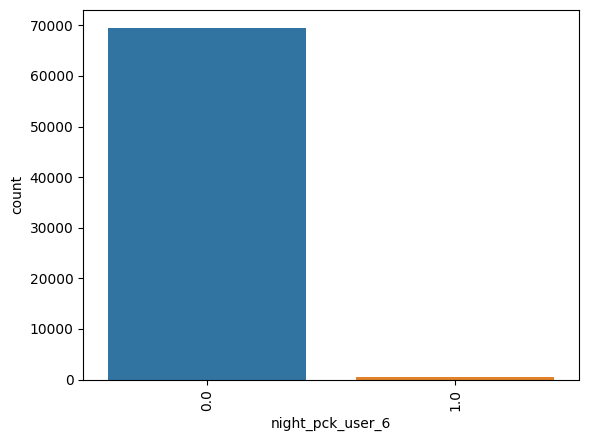

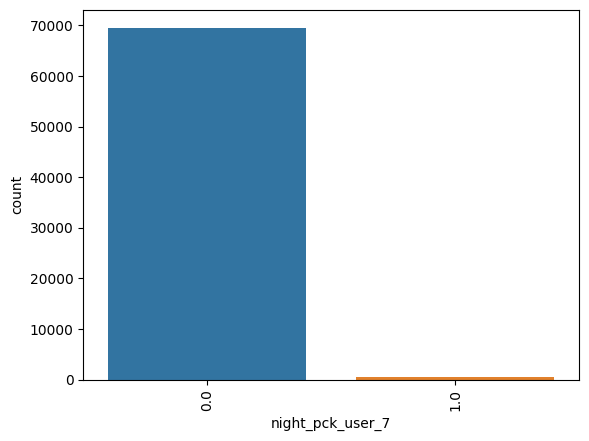

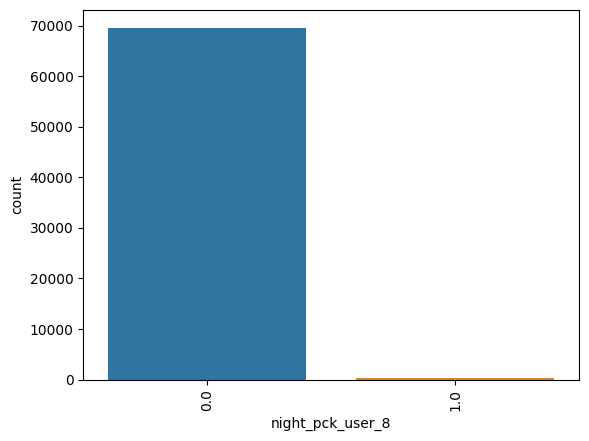

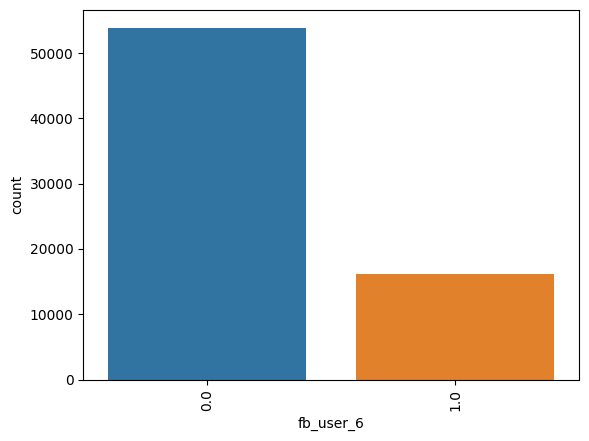

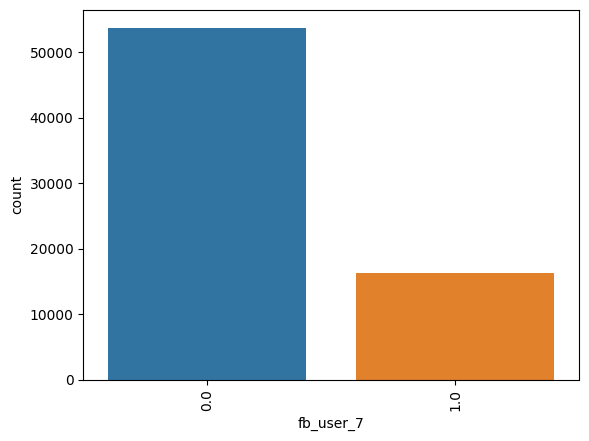

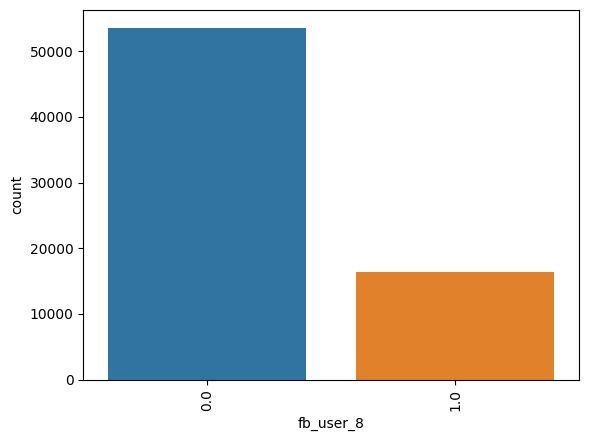

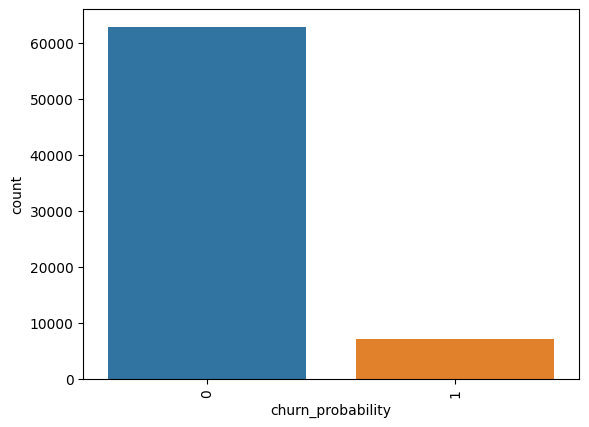

In [30]:
for column in cat_col:
  sns.countplot(data=train_df,x=column)
  plt.xticks(rotation=90)
  plt.show()

#### Bi-variate Analysis of churn_probability with other variables

In [31]:
for column in num_col:
  sns.barplot(data=train_df,x='churn_probability',y=column)
  plt.xticks(rotation=90)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

##### Observations from EDA

1) From univariate analysis of numeric columns it is found that all most all variables have skewed distribution and low variance.<br>
2) From univariate analysis of categorical columns, night pack recharge for any month is not useful for prediction of churn as it is very highly imbalanced. So we will drop these columns from our train_df. <br>
3) Our dataset is highly imbalanced as it has major observations for Non-churn customers.<br>
4) Bi-variate analysis of roaming data shows that roaming ic/og calls are playing major role for customer will be churned or not.<br>
5) Customers with std outgoing calls are more vulnerable that they will opt for another telecom operator in near future. Customers with ISD and special calls are showing same trend.<br>
6) Another interesting pattern is that customer who recharge their 2g/3g packs for less than one month period are switching operator.

#### Plot Heat-map for multivariate analysis

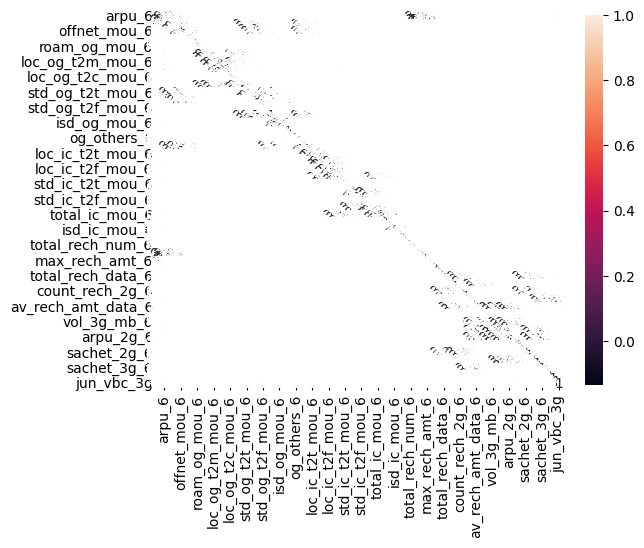

In [32]:
sns.heatmap(data=train_df.corr(),annot=True)
plt.show()

Heatmap is not feasible to visualize, as we have high dimensional dataset.<br>
Let's find multi-collinearity in another way.

In [33]:
corr_mat=train_df.corr()
multi_corr=[]
for i in range(len(corr_mat.columns)):
  for j in range(i):
    if abs(corr_mat.iloc[i,j])>=0.90 and abs(corr_mat.iloc[i,j])<1.0:
      multi_corr.append((corr_mat.columns[i],corr_mat.columns[j]))

In [34]:
## These are the highly correlated numeric features which have beyong 0.90 pearson correlation.So we will drop either one of them.
multi_corr

[('isd_og_mou_7', 'isd_og_mou_6'),
 ('isd_og_mou_8', 'isd_og_mou_6'),
 ('isd_og_mou_8', 'isd_og_mou_7'),
 ('total_rech_amt_6', 'arpu_6'),
 ('total_rech_amt_7', 'arpu_7'),
 ('total_rech_amt_8', 'arpu_8'),
 ('count_rech_2g_6', 'total_rech_data_6'),
 ('count_rech_2g_7', 'total_rech_data_7'),
 ('count_rech_2g_8', 'total_rech_data_8'),
 ('arpu_2g_6', 'arpu_3g_6'),
 ('arpu_2g_7', 'arpu_3g_7'),
 ('arpu_2g_8', 'arpu_3g_8'),
 ('sachet_2g_6', 'total_rech_data_6'),
 ('sachet_2g_6', 'count_rech_2g_6'),
 ('sachet_2g_7', 'total_rech_data_7'),
 ('sachet_2g_7', 'count_rech_2g_7'),
 ('sachet_2g_8', 'total_rech_data_8'),
 ('sachet_2g_8', 'count_rech_2g_8')]

In [35]:
drop_col=[]
for i in multi_corr:
  drop_col.append(i[0])

In [36]:
drop_col.extend(['night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8'])

Let's drop unnecessary columns from train_df which were identified using EDA


In [37]:
train_df=train_df.drop(drop_col,axis=1)

### Outlier Handling

In [38]:
## Handling outliers using percentile method
for col in train_df.columns:
    if train_df[col].dtype in [np.float64, np.int64]:
        percentiles = train_df[col].quantile([0.01, 0.98]).values
        train_df[col][train_df[col] <= percentiles[0]] = percentiles[0]
        train_df[col][train_df[col] >= percentiles[1]] = percentiles[1]

## Here, for every numeric column any value below min value or any value above 98th percentile vale will be replaced by min & 98th per. values respectively

# 3) Feature Engineering

From problem statement we can say that August month is action month in which operator should take action to prevent the customer to become churned.<br>
June & July are base months so we can say that difference between 8th month value and avg. value of 6th & 7th month will be more useful information to decide churn probability.


In [39]:
train_df['arpu_diff'] = train_df.arpu_8 - ((train_df.arpu_6 + train_df.arpu_7)/2)

train_df['onnet_mou_diff'] = train_df.onnet_mou_8 - ((train_df.onnet_mou_6 + train_df.onnet_mou_7)/2)

train_df['offnet_mou_diff'] = train_df.offnet_mou_8 - ((train_df.offnet_mou_6 + train_df.offnet_mou_7)/2)

train_df['roam_ic_mou_diff'] = train_df.roam_ic_mou_8 - ((train_df.roam_ic_mou_6 + train_df.roam_ic_mou_7)/2)

train_df['roam_og_mou_diff'] = train_df.roam_og_mou_8 - ((train_df.roam_og_mou_6 + train_df.roam_og_mou_7)/2)

train_df['loc_og_mou_diff'] = train_df.loc_og_mou_8 - ((train_df.loc_og_mou_6 + train_df.loc_og_mou_7)/2)

train_df['std_og_mou_diff'] = train_df.std_og_mou_8 - ((train_df.std_og_mou_6 + train_df.std_og_mou_7)/2)

# train_df['isd_og_mou_diff'] = train_df.isd_og_mou_8 - ((train_df.isd_og_mou_6 + train_df.isd_og_mou_7)/2)

train_df['spl_og_mou_diff'] = train_df.spl_og_mou_8 - ((train_df.spl_og_mou_6 + train_df.spl_og_mou_7)/2)

train_df['total_og_mou_diff'] = train_df.total_og_mou_8 - ((train_df.total_og_mou_6 + train_df.total_og_mou_7)/2)

train_df['loc_ic_mou_diff'] = train_df.loc_ic_mou_8 - ((train_df.loc_ic_mou_6 + train_df.loc_ic_mou_7)/2)

train_df['std_ic_mou_diff'] = train_df.std_ic_mou_8 - ((train_df.std_ic_mou_6 + train_df.std_ic_mou_7)/2)

train_df['isd_ic_mou_diff'] = train_df.isd_ic_mou_8 - ((train_df.isd_ic_mou_6 + train_df.isd_ic_mou_7)/2)

train_df['spl_ic_mou_diff'] = train_df.spl_ic_mou_8 - ((train_df.spl_ic_mou_6 + train_df.spl_ic_mou_7)/2)

# train_df['total_ic_mou_diff'] = train_df.total_ic_mou_8 - ((train_df.total_ic_mou_6 + train_df.total_ic_mou_7)/2)

train_df['total_rech_num_diff'] = train_df.total_rech_num_8 - ((train_df.total_rech_num_6 + train_df.total_rech_num_7)/2)

# train_df['total_rech_amt_diff'] = train_df.total_rech_amt_8 - ((train_df.total_rech_amt_6 + train_df.total_rech_amt_7)/2)

train_df['max_rech_amt_diff'] = train_df.max_rech_amt_8 - ((train_df.max_rech_amt_6 + train_df.max_rech_amt_7)/2)

train_df['total_rech_data_diff'] = train_df.total_rech_data_8 - ((train_df.total_rech_data_6 + train_df.total_rech_data_7)/2)

train_df['max_rech_data_diff'] = train_df.max_rech_data_8 - ((train_df.max_rech_data_6 + train_df.max_rech_data_7)/2)

train_df['av_rech_amt_data_diff'] = train_df.av_rech_amt_data_8 - ((train_df.av_rech_amt_data_6 + train_df.av_rech_amt_data_7)/2)

train_df['vol_2g_mb_diff'] = train_df.vol_2g_mb_8 - ((train_df.vol_2g_mb_6 + train_df.vol_2g_mb_7)/2)

train_df['vol_3g_mb_diff'] = train_df.vol_3g_mb_8 - ((train_df.vol_3g_mb_6 + train_df.vol_3g_mb_7)/2)

In [40]:
train_df.shape

(69999, 155)

In [41]:
train_df['churn_probability'].dtype

CategoricalDtype(categories=[0, 1], ordered=False)

In [42]:
train_df.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 155 columns):
 #    Column                 Dtype   
---   ------                 -----   
 0    arpu_6                 float64 
 1    arpu_7                 float64 
 2    arpu_8                 float64 
 3    onnet_mou_6            float64 
 4    onnet_mou_7            float64 
 5    onnet_mou_8            float64 
 6    offnet_mou_6           float64 
 7    offnet_mou_7           float64 
 8    offnet_mou_8           float64 
 9    roam_ic_mou_6          float64 
 10   roam_ic_mou_7          float64 
 11   roam_ic_mou_8          float64 
 12   roam_og_mou_6          float64 
 13   roam_og_mou_7          float64 
 14   roam_og_mou_8          float64 
 15   loc_og_t2t_mou_6       float64 
 16   loc_og_t2t_mou_7       float64 
 17   loc_og_t2t_mou_8       float64 
 18   loc_og_t2m_mou_6       float64 
 19   loc_og_t2m_mou_7       float64 
 20   loc_og_t2m_mou_8       float64 
 21   loc_og_t2f

#### Scaling of Numeric columns

Here, we don't need to do encoding as our all categorical columns are in '0' & '1' format

In [43]:
num_col=[]
for column in train_df.columns:
  if train_df[column].dtype in [np.float64, np.int64]:
    num_col.append(column)
print(len(num_col))

151


In [44]:
## We will apply standard scaling to all numeric columns
scaler=StandardScaler()

train_df[num_col]=scaler.fit_transform(train_df[num_col])

In [45]:
train_df.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,arpu_diff,onnet_mou_diff,offnet_mou_diff,roam_ic_mou_diff,roam_og_mou_diff,loc_og_mou_diff,std_og_mou_diff,spl_og_mou_diff,total_og_mou_diff,loc_ic_mou_diff,std_ic_mou_diff,isd_ic_mou_diff,spl_ic_mou_diff,total_rech_num_diff,max_rech_amt_diff,total_rech_data_diff,max_rech_data_diff,av_rech_amt_data_diff,vol_2g_mb_diff,vol_3g_mb_diff
0,-0.951333,-0.710803,-1.009299,-0.343152,0.017762,-0.562827,-0.653274,-0.367831,-0.775325,-0.296607,-0.273123,-0.278004,-0.315805,-0.287119,-0.291583,-0.556668,-0.589119,-0.599424,-0.702659,-0.606115,-0.739400,-0.437063,-0.437790,-0.441086,-0.342403,-0.349338,-0.361200,-0.715095,-0.662207,-0.751857,-0.134985,0.294323,-0.404329,-0.343664,0.009663,-0.456263,-0.274808,-0.269886,-0.275658,-0.302592,0.140464,-0.520631,-0.234567,0.708864,-0.412725,-0.505755,0.023819,-0.109715,-0.218706,-0.550632,-0.186735,-0.739494,-0.620592,-0.598796,-0.543893,-0.831084,-0.666752,-0.711463,-0.476927,-0.469236,-0.483337,-0.849616,-0.732719,-0.744694,-0.423055,0.041621,-0.410258,-0.271484,0.095309,-0.049442,-0.320483,-0.317991,-0.328565,-0.390895,0.002811,-0.242201,-0.804062,-0.619244,-0.670319,-0.445213,-0.308264,4.313589,-0.272398,-0.282165,-0.282988,0.620582,0.174640,-0.310043,-0.733264,-0.914928,-0.812718,-0.395955,-0.381568,-0.986825,0.101742,0.159291,-0.796305,-0.435197,-0.427034,-0.434802,-0.450797,-0.454065,-0.457724,-0.301423,-0.298780,-0.307295,-0.461338,-0.462848,-0.466265,-0.314489,-0.312746,-0.309853,-0.319445,-0.324317,-0.331906,-0.289034,-0.287168,-0.294988,-0.280417,-0.28633,-0.282751,-0.246478,-0.244122,-0.252967,-0.208305,-0.207819,-0.209385,0.0,0.0,0.0,0.784417,-0.318885,-0.309726,-0.303023,0,-0.260370,-0.593098,-0.371336,0.085549,0.086377,-0.080100,-0.638693,-0.660688,-0.518397,0.095140,-0.071136,-0.038199,4.019348,-0.020505,-0.755918,-0.044049,-0.019004,-0.029046,0.015305,-0.041397
1,-1.074370,-0.570294,-0.872160,-0.574792,-0.562808,-0.568955,-0.789742,-0.663839,-0.653445,-0.296607,-0.273123,-0.278004,-0.315805,-0.287119,-0.291583,-0.591300,-0.589119,-0.603985,-0.748335,-0.747585,-0.76

In [46]:
## Change dtype of categorical columns to int64
train_df['fb_user_6']=train_df['fb_user_6'].astype('int64')
train_df['fb_user_7']=train_df['fb_user_7'].astype('int64')
train_df['fb_user_8']=train_df['fb_user_8'].astype('int64')

# 4) Modelling

Train_Test_Split

In [47]:
# divide data into train and test
X = train_df.drop("churn_probability", axis = 1)
y = train_df.churn_probability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 4, stratify = y)

In [48]:
# print shapes of train and test sets
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(55999, 154) (55999,) (14000, 154) (14000,)


# A) Without PCA modelling

### In this part we will use logistic regression, random forest and XGBoost classifier with selected features

### Feature Selection using SelectKBest with mutual information

In [49]:
## We will use SelectKBest with mutual information technique for feature selection

selector = SelectKBest(score_func=mutual_info_classif, k=60)
selector.fit_transform(X_train, y_train)
selected_feature_indices = selector.get_support(indices=True)
selected_features = X_train.columns[selected_feature_indices]

In [50]:
selected_features

Index(['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_7',
       'loc_og_t2t_mou_8', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8',
       'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_8', 'std_og_t2m_mou_8',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_8', 'spl_og_mou_8',
       'og_others_8', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_7',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8',
       'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_mou_7', 'loc_ic_mou_8',
       'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_7',
       'std_ic_t2f_mou_8', 'std_ic_mou_8', 'total_ic_mou_7', 'total_ic_mou_8',
       'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8',
       'max_rech_amt_8', 'last_day_rch_amt_8', 'arpu_diff', 'onnet_mou_diff',
       'offnet_mou_diff', 'roam_ic_mou_diff

In [51]:
## Modified X_train with selected_features
X_train_modified=X_train[list(selected_features)]

In [52]:
X_test_modified=X_test[list(selected_features)]

In [53]:
# Define stratified k-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# We will use class_weight to handle heavy class imbalancing in our data
# Logistic Regression
logreg = LogisticRegression(class_weight='balanced')
logreg_wo_tuned=logreg.fit(X_train_modified, y_train)

# Random Forest
rf = RandomForestClassifier(class_weight='balanced')
rf_wo_tuned=rf.fit(X_train_modified, y_train)

# XGBoost
xgb = XGBClassifier()
xgb_wo_tuned=xgb.fit(X_train_modified, y_train)

# CatBoost
catboost = CatBoostClassifier()
catboost_wo_tuned=catboost.fit(X_train_modified, y_train)

Learning rate set to 0.057465
0:	learn: 0.6059604	total: 108ms	remaining: 1m 48s
1:	learn: 0.5439277	total: 147ms	remaining: 1m 13s
2:	learn: 0.4900499	total: 180ms	remaining: 59.7s
3:	learn: 0.4409667	total: 218ms	remaining: 54.4s
4:	learn: 0.3986875	total: 251ms	remaining: 50s
5:	learn: 0.3681883	total: 294ms	remaining: 48.6s
6:	learn: 0.3368157	total: 326ms	remaining: 46.3s
7:	learn: 0.3119903	total: 365ms	remaining: 45.3s
8:	learn: 0.2901634	total: 404ms	remaining: 44.4s
9:	learn: 0.2745931	total: 441ms	remaining: 43.6s
10:	learn: 0.2608747	total: 483ms	remaining: 43.4s
11:	learn: 0.2476429	total: 518ms	remaining: 42.6s
12:	learn: 0.2373849	total: 566ms	remaining: 43s
13:	learn: 0.2302535	total: 599ms	remaining: 42.2s
14:	learn: 0.2219316	total: 637ms	remaining: 41.9s
15:	learn: 0.2145920	total: 677ms	remaining: 41.6s
16:	learn: 0.2096200	total: 713ms	remaining: 41.2s
17:	learn: 0.2055163	total: 745ms	remaining: 40.7s
18:	learn: 0.2006717	total: 778ms	remaining: 40.2s
19:	learn: 0.

In [54]:
scorer = make_scorer(recall_score)   ## select scoring as sensitivity

In [56]:
# Function to perform hyperparameter tuning using GridSearchCV with stratified k-fold cross-validation
def tune_model(model, params):
    grid = GridSearchCV(model, params, scoring=scorer, cv=kf,n_jobs=-1)   ## scoring should be recall_score because we are more interested for churn
    grid.fit(X_train_modified, y_train)
    return grid.best_estimator_

# Hyperparameter tuning for Logistic Regression
logreg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                 'penalty': ['l1', 'l2'],
                 'class_weight': ['balanced'],
                 'solver': ['liblinear', 'saga']}
logreg_tuned = tune_model(logreg, logreg_params)

In [58]:
# Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None,5, 10,20]
}
rf_tuned=tune_model(rf, rf_params)

In [104]:
# Hyperparameter tuning for XGBoost
xgb_params = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200, 300]
}
xgb_tuned=tune_model(xgb, xgb_params)

In [111]:
# Evaluate the models on the test set
y_pred_logreg = logreg_wo_tuned.predict(X_test_modified)
y_pred_rf = rf_wo_tuned.predict(X_test_modified)
y_pred_xgb = xgb_wo_tuned.predict(X_test_modified)
y_pred_catboost=catboost_wo_tuned.predict(X_test_modified)
y_pred_logreg_tuned = logreg_tuned.predict(X_test_modified)
y_pred_rf_tuned = rf_tuned.predict(X_test_modified)


#### Sensitivity , specificity & ROC_AUC_Score

In Churn_prediction case customer who will be churned will require to be identified more precisely rather than non-churn. So we have used sensitivity & specificiy as our evaluation metrics

In [113]:
print("Logistic Regression:")
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred_logreg, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')
# check area under curve
y_pred_prob = logreg_wo_tuned.predict_proba(X_test_modified)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

print("\n\nRandom Forest:")
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred_rf, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')
# check area under curve
y_pred_prob = rf_wo_tuned.predict_proba(X_test_modified)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

print("\n\nXG_Boost:")
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred_xgb, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')
# check area under curve
y_pred_prob = xgb_wo_tuned.predict_proba(X_test_modified)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

print("\n\nCatBoost:")
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred_catboost, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')
# check area under curve
y_pred_prob = catboost_wo_tuned.predict_proba(X_test_modified)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

print("\n\nLogistic Regression Finetuned:")
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred_logreg_tuned, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')
# check area under curve
y_pred_prob = logreg_tuned.predict_proba(X_test_modified)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

print("\n\nRandom Forest Finetuned:")
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred_rf_tuned, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')
# check area under curve
y_pred_prob = rf_tuned.predict_proba(X_test_modified)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

Logistic Regression:
Sensitivity: 	0.85
Specificity: 	0.86
AUC:    	 0.91


Random Forest:
Sensitivity: 	0.57
Specificity: 	0.98
AUC:    	 0.94


XG_Boost:
Sensitivity: 	0.63
Specificity: 	0.98
AUC:    	 0.94


CatBoost:
Sensitivity: 	0.63
Specificity: 	0.98
AUC:    	 0.94


Logistic Regression Finetuned:
Sensitivity: 	0.84
Specificity: 	0.84
AUC:    	 0.9


Random Forest Finetuned:
Sensitivity: 	0.81
Specificity: 	0.91
AUC:    	 0.93


From, above result we can say that Logistic regression is the best model for our top 60 selected features

# B) With PCA modelling

In [61]:
# Instantiate PCA
pca=PCA(random_state=42)

In [62]:
pca.fit(X_train)

PCA(random_state=42)

Making Scree plot for explained variance

In [63]:
var_cumu=np.cumsum(pca.explained_variance_ratio_)

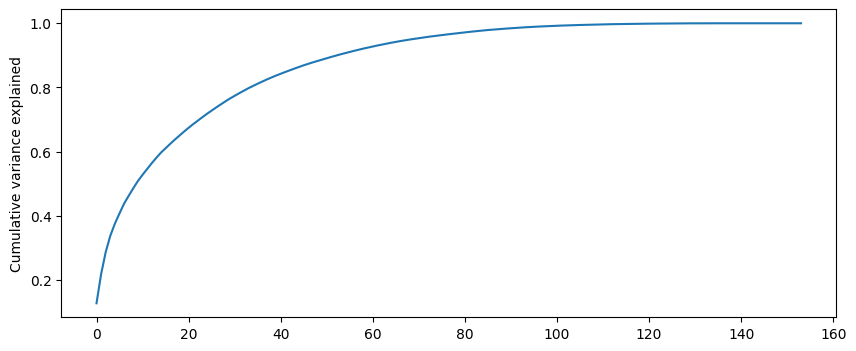

In [64]:
fig = plt.figure(figsize=[10,4])
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

From above scree plot we can say that about 95% of variance of data is explained by 80 principal components

In [65]:
pca_final=PCA(n_components=80,random_state=42)

In [66]:
X_train_pca=pca_final.fit_transform(X_train)
X_test_pca=pca_final.transform(X_test)

Now, we will perform Logistic regression & random_forest on this pca dataset

In [67]:
# Logistic Regression
logreg = LogisticRegression(class_weight='balanced')
logreg_pca=logreg.fit(X_train_pca, y_train)

# Random Forest
rf = RandomForestClassifier(class_weight='balanced')
rf_pca=rf.fit(X_train_pca, y_train)

In [68]:
# Function to perform hyperparameter tuning using GridSearchCV with stratified k-fold cross-validation
def tune_model(model, params):
    grid = GridSearchCV(model, params, scoring='f1', cv=kf,n_jobs=-1)
    grid.fit(X_train_pca, y_train)
    return grid.best_estimator_

# Hyperparameter tuning for Logistic Regression
logreg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                 'penalty': ['l1', 'l2'],
                 'class_weight': ['balanced'],
                 'solver': ['liblinear', 'saga']}
logreg_tuned_pca = tune_model(logreg, logreg_params)

In [69]:
# Evaluate the models on the test set
y_pred_logreg_pca = logreg_pca.predict(X_test_pca)
y_pred_rf_pca = rf_pca.predict(X_test_pca)
y_pred_logreg_tuned_pca = logreg_tuned_pca.predict(X_test_pca)

In [70]:
print("Logistic Regression PCA:")
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred_logreg_pca, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')
# check area under curve
y_pred_prob = logreg_pca.predict_proba(X_test_pca)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

print("\n\nRandom Forest PCA:")
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred_rf_pca, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')
# check area under curve
y_pred_prob = rf_pca.predict_proba(X_test_pca)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))


print("\n\nLogistic Regression Finetuned PCA:")
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred_logreg_tuned_pca, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')
# check area under curve
y_pred_prob = logreg_tuned_pca.predict_proba(X_test_pca)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

Logistic Regression PCA:
Sensitivity: 	0.84
Specificity: 	0.85
AUC:    	 0.91


Random Forest PCA:
Sensitivity: 	0.32
Specificity: 	0.99
AUC:    	 0.91


Logistic Regression Finetuned PCA:
Sensitivity: 	0.83
Specificity: 	0.85
AUC:    	 0.91


From above results we conclude that Feature selection with SelectKBest with mutual information and using PCA gives us same accuracy.


# 5) Submission file of churn_prediction from test dataset

We will use fine-tuned Random Forest model for churn_prediction

#### Following all the steps as above for test dataset

In [71]:
test_df=unseen_df.copy()

In [72]:
# Dropping single unique value columns
test_df=test_df.drop(single_unique_columns,axis=1)

In [73]:
# Imputation with '0' for selected columns
test_df[recharge_col]=test_df[recharge_col].apply(lambda x:x.fillna(0))

In [74]:
drop_col=['id','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8',
          'date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8']

In [75]:
test_df=test_df.drop(drop_col,axis=1)

In [76]:
# test_df=test_df.dropna()

In [77]:
# Imputation using Iterative imputer

columns_with_missing = test_df.columns[test_df.isnull().any()].tolist()
imputed_data = imputer.fit_transform(test_df[columns_with_missing])
test_df[columns_with_missing] = imputed_data

In [78]:
test_df.shape

(30000, 151)

In [79]:
cat_col=['night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8']

In [80]:
# Change dtype of categorical columns

test_df[cat_col] = test_df[cat_col].apply(lambda column: column.astype("category"), axis=0)

In [81]:
# Dropping highly correlated features and reducing multi-collinearity

multi_corr=[('isd_og_mou_7', 'isd_og_mou_6'),
 ('isd_og_mou_8', 'isd_og_mou_6'),
 ('isd_og_mou_8', 'isd_og_mou_7'),
 ('total_ic_mou_6', 'loc_ic_mou_6'),
 ('total_rech_amt_6', 'arpu_6'),
 ('total_rech_amt_7', 'arpu_7'),
 ('total_rech_amt_8', 'arpu_8'),
 ('count_rech_2g_6', 'total_rech_data_6'),
 ('count_rech_2g_7', 'total_rech_data_7'),
 ('count_rech_2g_8', 'total_rech_data_8'),
 ('arpu_2g_6', 'arpu_3g_6'),
 ('arpu_2g_7', 'arpu_3g_7'),
 ('arpu_2g_8', 'arpu_3g_8'),
 ('sachet_2g_6', 'total_rech_data_6'),
 ('sachet_2g_6', 'count_rech_2g_6'),
 ('sachet_2g_7', 'total_rech_data_7'),
 ('sachet_2g_7', 'count_rech_2g_7'),
 ('sachet_2g_8', 'total_rech_data_8'),
 ('sachet_2g_8', 'count_rech_2g_8')]

In [82]:
drop_col=[]
for i in multi_corr:
  drop_col.append(i[0])

In [83]:
drop_col.extend(['night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8'])

In [84]:
test_df=test_df.drop(drop_col,axis=1)

In [85]:
# Removing outliers from numeric features

for col in test_df.columns:
    if test_df[col].dtype in [np.float64, np.int64]:
        percentiles = test_df[col].quantile([0.01, 0.98]).values
        test_df[col][test_df[col] <= percentiles[0]] = percentiles[0]
        test_df[col][test_df[col] >= percentiles[1]] = percentiles[1]

In [86]:
## Do Feature engineering same as train_df
test_df['arpu_diff'] = test_df.arpu_8 - ((test_df.arpu_6 + test_df.arpu_7)/2)

test_df['onnet_mou_diff'] = test_df.onnet_mou_8 - ((test_df.onnet_mou_6 + test_df.onnet_mou_7)/2)

test_df['offnet_mou_diff'] = test_df.offnet_mou_8 - ((test_df.offnet_mou_6 + test_df.offnet_mou_7)/2)

test_df['roam_ic_mou_diff'] = test_df.roam_ic_mou_8 - ((test_df.roam_ic_mou_6 + test_df.roam_ic_mou_7)/2)

test_df['roam_og_mou_diff'] = test_df.roam_og_mou_8 - ((test_df.roam_og_mou_6 + test_df.roam_og_mou_7)/2)

test_df['loc_og_mou_diff'] = test_df.loc_og_mou_8 - ((test_df.loc_og_mou_6 + test_df.loc_og_mou_7)/2)

test_df['std_og_mou_diff'] = test_df.std_og_mou_8 - ((test_df.std_og_mou_6 + test_df.std_og_mou_7)/2)

# train_df['isd_og_mou_diff'] = train_df.isd_og_mou_8 - ((train_df.isd_og_mou_6 + train_df.isd_og_mou_7)/2)

test_df['spl_og_mou_diff'] = test_df.spl_og_mou_8 - ((test_df.spl_og_mou_6 + test_df.spl_og_mou_7)/2)

test_df['total_og_mou_diff'] = test_df.total_og_mou_8 - ((test_df.total_og_mou_6 + test_df.total_og_mou_7)/2)

test_df['loc_ic_mou_diff'] = test_df.loc_ic_mou_8 - ((test_df.loc_ic_mou_6 + test_df.loc_ic_mou_7)/2)

test_df['std_ic_mou_diff'] = test_df.std_ic_mou_8 - ((test_df.std_ic_mou_6 + test_df.std_ic_mou_7)/2)

test_df['isd_ic_mou_diff'] = test_df.isd_ic_mou_8 - ((test_df.isd_ic_mou_6 + test_df.isd_ic_mou_7)/2)

test_df['spl_ic_mou_diff'] = test_df.spl_ic_mou_8 - ((test_df.spl_ic_mou_6 + test_df.spl_ic_mou_7)/2)

# train_df['total_ic_mou_diff'] = train_df.total_ic_mou_8 - ((train_df.total_ic_mou_6 + train_df.total_ic_mou_7)/2)

test_df['total_rech_num_diff'] = test_df.total_rech_num_8 - ((test_df.total_rech_num_6 + test_df.total_rech_num_7)/2)

# train_df['total_rech_amt_diff'] = train_df.total_rech_amt_8 - ((train_df.total_rech_amt_6 + train_df.total_rech_amt_7)/2)

test_df['max_rech_amt_diff'] = test_df.max_rech_amt_8 - ((test_df.max_rech_amt_6 + test_df.max_rech_amt_7)/2)

test_df['total_rech_data_diff'] = test_df.total_rech_data_8 - ((test_df.total_rech_data_6 + test_df.total_rech_data_7)/2)

test_df['max_rech_data_diff'] = test_df.max_rech_data_8 - ((test_df.max_rech_data_6 + test_df.max_rech_data_7)/2)

test_df['av_rech_amt_data_diff'] = test_df.av_rech_amt_data_8 - ((test_df.av_rech_amt_data_6 + test_df.av_rech_amt_data_7)/2)

test_df['vol_2g_mb_diff'] = test_df.vol_2g_mb_8 - ((test_df.vol_2g_mb_6 + test_df.vol_2g_mb_7)/2)

test_df['vol_3g_mb_diff'] = test_df.vol_3g_mb_8 - ((test_df.vol_3g_mb_6 + test_df.vol_3g_mb_7)/2)

In [87]:
# Standard scaling of test_df
num_col_test=[]
for column in test_df.columns:
  if test_df[column].dtype in [np.float64, np.int64]:
    num_col_test.append(column)

test_df[num_col_test]=scaler.fit_transform(test_df[num_col_test])
test_df['fb_user_6']=test_df['fb_user_6'].astype('int64')
test_df['fb_user_7']=test_df['fb_user_7'].astype('int64')
test_df['fb_user_8']=test_df['fb_user_8'].astype('int64')

In [88]:
submission_df=test_df[list(selected_features)]

In [114]:
# Churn Prediction with our best performing model

y_prediction=rf_tuned.predict(submission_df)

In [115]:
unseen_df['churn_probability']=y_prediction

In [116]:
output=unseen_df[['id','churn_probability']]

In [117]:
output.to_csv('submission.csv',index=False)

# 6) Recommendations & Conclusion

### A) We will find out top_20 predictors for churn_predicton using Fine-tuned Random Forest

In [103]:
# Get feature importances from the trained model
importances = rf_tuned.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Get the top 20 feature indices and importances
top_10_indices = indices[:20]
top_10_importances = importances[top_10_indices]

# Get the names of the top 10 features
feature_names = X_train_modified.columns
top_10_features = feature_names[top_10_indices]

# Print the top 10 features and their importances
print("Top 20 Features:")
for feature, importance in zip(top_10_features, top_10_importances):
    print(f"{feature}: {importance}")

Top 20 Features:
total_ic_mou_8: 0.1762186867758481
total_og_mou_8: 0.10819310531926687
roam_og_mou_8: 0.0908933374972432
roam_ic_mou_8: 0.07268702400486239
last_day_rch_amt_8: 0.0660068368331569
arpu_8: 0.04988203789670077
max_rech_amt_8: 0.037865104334476186
loc_ic_mou_8: 0.03751103573267426
roam_og_mou_diff: 0.032622911716967726
max_rech_amt_diff: 0.030145301686249324
total_ic_mou_7: 0.029492456048195097
arpu_diff: 0.025783112385610103
total_og_mou_diff: 0.02265056967152532
loc_ic_t2m_mou_8: 0.022510553074872954
og_others_8: 0.021095116396744433
roam_ic_mou_diff: 0.01650000212495636
std_og_t2f_mou_8: 0.015141584764889974
loc_og_t2m_mou_8: 0.012014044792576381
loc_og_mou_8: 0.01132386272950905
roam_og_mou_7: 0.011200568123748748


### B) Business_insights

1) From EDA & modelling we found that customers who use roaming, STD, ISD & special services are more prone to be churned. So, telecom operator should provide good  schemes to these customers.<br>
2) Customers whose total outgoing minutes are continuously reducing then they may opt for another telecom services.<br>
3) Majority of churn customers show same trend--- maximum recharge amount & maximum recharge amount for data will reduce in steady manner.So provide relevant good recharge schemes to these type of customers.

